In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import *
from src.lobe.lobe_circuit import lobe_circuit
import numpy as np
import matplotlib.pyplot as plt

/Users/carterm.gustin/anaconda3/envs/phd/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


# Static Yukawa Hamiltonian:

$H = E_f b^\dagger b + E_b a^\dagger a + gE_I b^\dagger (a^\dagger + a)b$

The infinite limit of this Hamiltonian is when `max_bose_occ` $\geq 200$

In [2]:
Ef, Eb, Ei = 1, 1, 1
g0 = 10
max_bose_occ = 200

In [3]:
H0 = Ef * ParticleOperator('b0^ b0') + Eb * ParticleOperator('a0^ a0')
Hi = g0 * Ei * (ParticleOperator('b0^') * (
    ParticleOperator('a0^') + ParticleOperator('a0')
    )*ParticleOperator('b0') )
Hcan = H0 + Hi

In [4]:
f = Fock([0], [], [])
interact = [Fock([0], [], [(0, i)]) for i in range(1, max_bose_occ)]
basis =[f] + interact

In [5]:
H0_mat = generate_matrix(Hcan, basis)

Text(0.5, 1.0, '$E_0 = -99.00000000000006$')

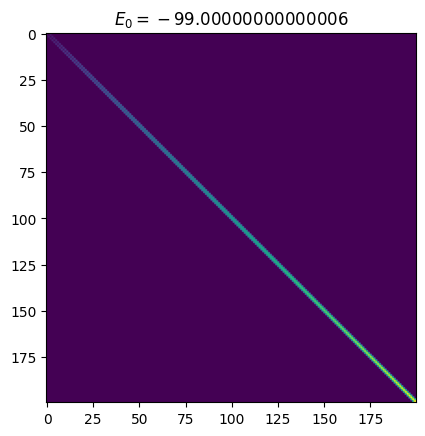

In [6]:
plt.imshow(H0_mat)
plt.title(f"$E_0 = {min(np.linalg.eigvalsh(H0_mat))}$" )

To block encode this "infinite" matrix with `max_bose_occ = 200` would be very expensive. Alternatively, we can solve the RGPEP equation to find the effective Hamiltonian $H(t)$ and then cut off `max_bose_occ` at a _much_ smaller value, making it easier to use LOBE.

After solving the RGPEP equation, we get the effective Hamiltonian, parameterized by $t$:
$$H(t) = [E_f + g^2(1 - e^{-2E_b^2t})E_I^2/E_b]b^\dagger b + E_b a^\dagger a + ge^{-2E_bt}E_I b^\dagger (a^\dagger + a)b$$

In [7]:
def g(t):
    return g0 * np.exp(-Eb**2 * t)

def Delta(t):
    return (1 - np.exp(2 * Eb**2 * t)) * Eb**2 / Ei

In [8]:
def H(t):
    return (Ef + g(t)**2 * Delta(t)) * ParticleOperator('b0^ b0')+\
    Eb * ParticleOperator('a0^ a0') +\
    g(t) * Ei * (ParticleOperator('b0^') * (
    ParticleOperator('a0^') + ParticleOperator('a0')
    )*ParticleOperator('b0') )

In [9]:
#Infinite-limit model Hamiltonian ground state we look to obtain with LOBE

vals = np.linalg.eigvalsh(generate_matrix(H(0), basis))
print("E0 in infinite limit of model Hamiltonian: ", min(vals))

E0 in infinite limit of model Hamiltonian:  -99.00000000000006


-98.96645373720973 * b0^ b0
1.0 * a0^ a0
0.1831563888873418 * b0^ a0^ b0
0.1831563888873418 * b0^ a0 b0

E_0: -98.99999979818934


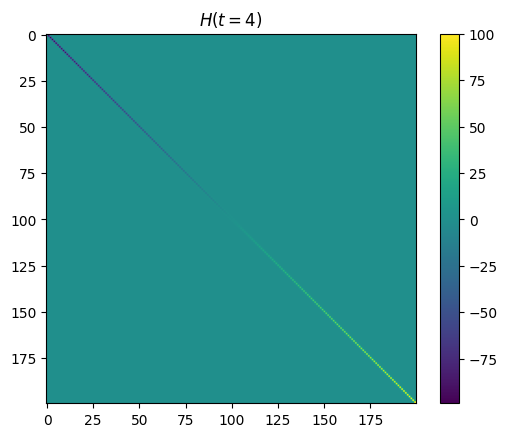

In [10]:
t = 4 #choose large enough t
print(H(t))

#matrix form of H(t)
Hmat_t = generate_matrix(H(t), basis) 

plt.imshow(Hmat_t)
plt.colorbar()
plt.title(f'$H(t = {t})$')

#get eigenvalues
vals_t = np.linalg.eigvalsh(Hmat_t[:4, :4]) #Cut off effective Hamiltonian at much smaller value of max_bose_occ (here it is 3)
print("E_0:", min(vals_t)) #(vals_t10[vals_t10 > 0].min()))

E0:  -98.99999979818934


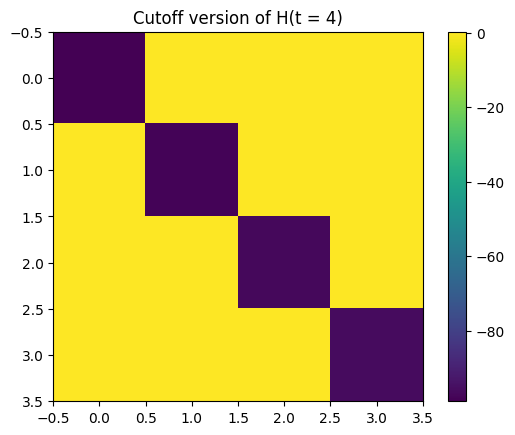

In [11]:
plt.imshow(Hmat_t[:4, :4])
plt.colorbar()
plt.title("Cutoff version of H(t = 4)")
print("E0: ", min(np.linalg.eigvalsh(Hmat_t[:4, :4])))
plt.show()

The cutoff effective Hamiltonian $H(t = 4)$ with `max_bose_occ = 3` (so that there are 4 basis states (see below)) obtains a ground state of $E_0 = -98.99999979818934$ vs. the infinite limit model Hamiltonian $E_0 = -99.00000000000006$. This is a percent error of $-2.0384921315486967e-07 \%$

In [12]:
circuit, unitary, matrix = lobe_circuit(H(4).normal_order(), max_bose_occ=3)

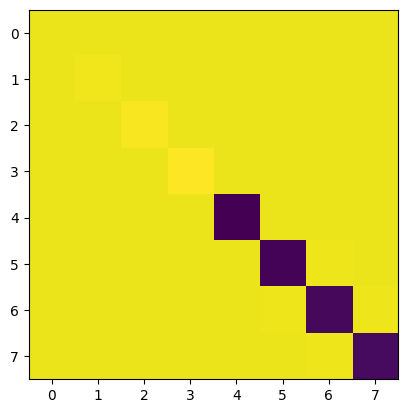

In [13]:
plt.imshow(np.real(unitary))

@Will: I'm not too certain as to why this is 8x8. The cutoff matrix (Cutoff version of H(t = 4) above) is 4x4 with the basis states being `Fock([0], [], []), Fock([0], [], [(0, 1)]), Fock([0], [], [(0, 2)]), Fock([0], [], [(0, 3)])` respecitvely. Do you know why this matrix above from the unitary is 8x8? I still get the same ground state $E_0$ so _maybe_ it doesn't matter? 


## Main Takeaway:

Instead of diagonalizing the "infinite" (`200x200`) model Hamiltonian ($t = 0$) or the full "infinite" effective Hamiltonian $H(t)$ with $t > 0$, we can diagonalize a much smaller version of the effective Hamiltonian, say 4x4  (with appropriately large t) and obtain the same ground state as the infinite limit. Thus, the Hamiltonian above $H(t = 4)$, can be simulated with LOBE with `max_bose_occ = 3`  to obtain the same ground state as the infinite Hamiltonian with a very small error.